# MBA em Ciência de Dados
# Técnicas Avançadas de Captura e Tratamento de Dados


### <span style="color:darkred">Módulo II - Tratamento de Dados</span>


### <span style="color:darkred">Tratamento de desbalanceamento: SMOTE e data augmentation</span>

Material Produzido por Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

__Conteúdo:__
1. Detecção de outliers: métodos estatísticos e de aprendizado de máquina
2. Limpeza de dados: tratamento de informações faltantes, redundantes e errôneas
3. *Tratamento de desbalanceamento: SMOTE e data augmentation*

__Referências:__
- Katti Faceli; Ana Carolina Lorena; João Gama; André C.P.L.F. Carvalho. Inteligência Artificial: uma abordagem de aprendizado de máquina, 2011.
- Salvador García, Julián Luengo, Francisco Herrera. Data Processing in Data Mining, 2015.
- Hadley Wickham, Tidy Data. Journal of Statistical Software, v.59, n.10, 2014.


***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn import combine

In [3]:
# https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent
data = pd.read_csv("./dados/houses_to_rent_mba_nomissing2.csv")

data_nred = data.drop_duplicates(keep='first')

data_nred.loc[data_nred['floor']=='-','floor'] = '0'
data_nred.loc[:,'floor'] = pd.to_numeric(data_nred['floor'], downcast='integer', errors='coerce')

def remove_nans_outliers(df, attributes):
    
    dfn = df.copy()
    
    for var in attributes:
        # verifica se variável é numerica
        if np.issubdtype(df[var].dtype, np.number):
            Q1 = df[var].quantile(0.25)
            Q2 = df[var].quantile(0.25)
            Q3 = df[var].quantile(0.75)
            IQR = Q3 - Q1
        
        # apenas inliers segundo IQR
        dfn = df.loc[(df[var] >= Q1-(IQR*1.5)) & (df[var] <= Q3+(IQR*1.5)), :]
        dfn = dfn.loc[dfn[var].notnull(),:]
        
    return dfn

attributes = ['tax','insurance', 'hoa', 'rent']

data_out = remove_nans_outliers(data_nred, attributes)

print("Antes: %d, Depois remocao outliers: %d" % (data_nred.shape[0], data_out.shape[0]))

Antes: 10695, Depois remocao outliers: 9980


Vamos separar essa base de dados em conjuntos de treinamento (X) e teste (Z)

In [4]:
# sorteia aproximadamente 80% dos dados para treinamento
np.random.seed(2)

n_train = np.round(data_out.shape[0]*0.80)
print(n_train)
indices_train = np.random.rand(data_out.shape[0]) < 0.8
dtrain = data_out[indices_train]
dtest = data_out[~indices_train]

7984.0


Agora vamos treinar:
1. classificador para predizer a **cidade** com base no imposto, valor do condomínio e valor do seguro, e valor do condomínio

In [5]:
# Treinando classificador
X = dtrain[['tax','insurance', 'hoa']]
Y = dtrain['city']

ZX = dtest[['tax','insurance', 'hoa']]
ZY = dtest['city']

clf = SVC(gamma='auto')
clf.fit(X,Y)
ZY_ = clf.predict(ZX)

In [12]:
dtrain

,city,area,rooms,bathroom,parking spaces,floor,hoa,rent,tax,insurance,total,interactions,weeks available,type
0,São Paulo,70,2,1,1,7,3098,3300,400,42,5618,108,3,flat
1,São Paulo,320,4,4,0,20,1800,4960,2625,63,7973,240,11,flat
2,Porto Alegre,80,1,1,1,6,800,2800,0,29,3841,128,38,flat
3,Porto Alegre,51,2,1,0,2,216,1112,22,12,1421,92,10,flat
4,São Paulo,25,1,1,0,1,0,800,38,11,836,516,11,flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10685,São Paulo,83,3,2,2,11,1332,7521,332,96,8726,372,12,flat
10689,Rio de Janeiro,70,3,3,0,8,980,6000,398,78,7390,488,16,flat
11220,São Paulo,50,1,1,1,0,0,1600,0,25,1625,72,7,house
11228,São Paulo,65,2,1,2,3,885,2748,0,25,3479,504,12,flat


In [6]:
acc_base = metrics.accuracy_score(ZY, ZY_)
accb_base = metrics.balanced_accuracy_score(ZY, ZY_)
print("Acurácia: %0.3f" % (acc_base))
print("Acurácia balanceada base: %0.3f" % (accb_base))

Acurácia: 0.565
Acurácia balanceada base: 0.275


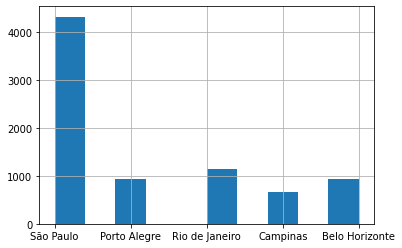

In [7]:
dtrain['city'].hist()

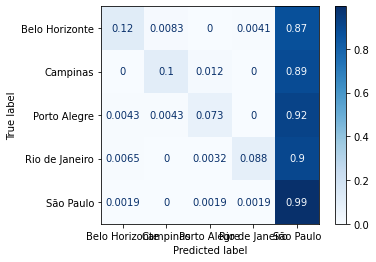

In [8]:
disp = plot_confusion_matrix(clf, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

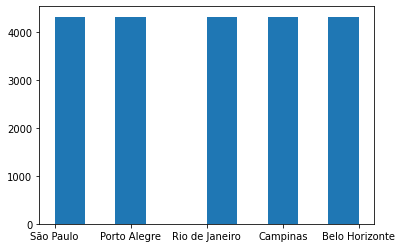

In [9]:
oversamp = over_sampling.SMOTE() # sampling_strategy pode ser usado para casos binários
Xo, Yo = oversamp.fit_resample(X, Y)
h = plt.hist(Yo)

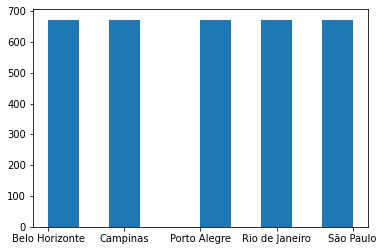

In [13]:
undersamp = under_sampling.RandomUnderSampler()
Xu, Yu = undersamp.fit_resample(X, Y)

h = plt.hist(Yu)

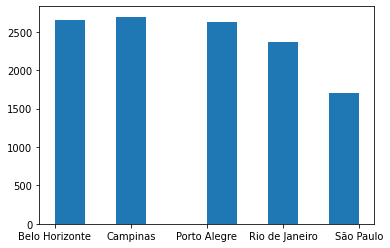

In [14]:
overunder = combine.SMOTEENN(sampling_strategy='all')
Xc, Yc = overunder.fit_resample(X, Y)

h = plt.hist(Yc)

In [15]:
clf_ov = SVC(gamma='auto')
clf_ov.fit(Xo,Yo)
ZYov_ = clf_ov.predict(ZX)

clf_un = SVC(gamma='auto')
clf_un.fit(Xu,Yu)
ZYun_ = clf_un.predict(ZX)

clf_co = SVC(gamma='auto')
clf_co.fit(Xc,Yc)
ZYco_ = clf_co.predict(ZX)

In [16]:
accb_ov = metrics.balanced_accuracy_score(ZY, ZYov_)
accb_un = metrics.balanced_accuracy_score(ZY, ZYun_)
accb_co = metrics.balanced_accuracy_score(ZY, ZYco_)
print("Acurácia balanceada base: %0.3f" % (accb_base))
print("Acurácia balanceada oversampling: %0.3f" % (accb_ov))
print("Acurácia balanceada undersampling: %0.3f" % (accb_un))
print("Acurácia balanceada combinado: %0.3f" % (accb_co))

Acurácia balanceada base: 0.275
Acurácia balanceada oversampling: 0.336
Acurácia balanceada undersampling: 0.304
Acurácia balanceada combinado: 0.324


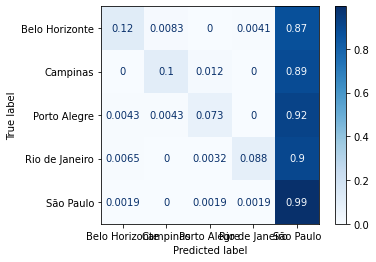

In [17]:
disp = plot_confusion_matrix(clf, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

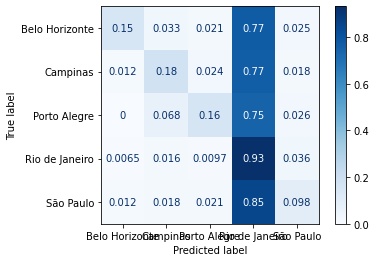

In [18]:
disp = plot_confusion_matrix(clf_un, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

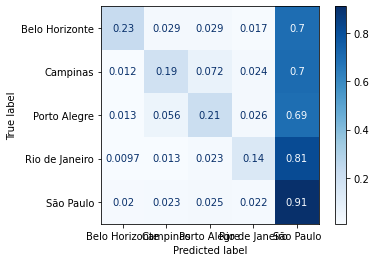

In [19]:
disp = plot_confusion_matrix(clf_ov, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### Resumo

* desbalanceamento também pode ser um problema relevante em bases de dados reais
* ganhos significativos podem ser obtidos por meio de métodos de amostragem
